<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/Future_work/qSK_VQE%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np

We are studying VQE optimization problem defined as minimization of Hamiltonian expectation value:

$E(\theta) = \langle 0| U^{\dagger}(\theta) H U(\theta)|0\rangle$,

where $H$ is a Hamiltonian operator, and $U(\theta)$ is a parametrized unitary matrix.

We study here the $N$-qubit quantum Sherrington-Kickpatrick model in the transverse field. It is defined by the following Hamiltonian:

$H = \sum_{(ij)} J_{ij} \sigma_{i}^{z} \sigma_{j}^{z} -g \sum_{i} \sigma_{i}^{x}$,

where the first sum if over all pairs of sites $(ij)$ and $J_{ij} = \mathcal{N}(0, 1)/ \sqrt{N}$ are sampled from the normal distribution with zero mean and $1/N$ variance. At small $g < 1.5$ the model is generally in the localized spin glass phase. At large $g$ the model becomes paramagnetic in the $x$ direction.

We would search for the model ground state in the glass regime, where there is a potential for local minimas in the energy landscape due to localization.

For the recent discussion of the model physics and of potential ground state ansatzes see P. M. Schindler, T. Guaita, T. Shi, E. Demler, and J. I. Cirac, Variational Ansatz for the Ground State of the Quantum Sherrington-Kirkpatrick Model
 https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.220401

In [ ]:
# define parameters in H
N = 8      #number of qubits
rng = np.random.default_rng(seed=1)
g = 1.2    #Coupling of the transverse field
ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(N) for j in range(i+1,N)]
ZZ_coeff = [rng.normal()/np.sqrt(N) for i in range(N) for j in range(i+1,N)]
X = [qml.PauliX(i) for i in range(N)]
X_coeff = [-g for i in range(N)]
# Construct the Hamiltonian
obs = ZZ + X
coeffs = ZZ_coeff + X_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

The model Hamiltonian is real valued. Hence, the wave function ansatz can be also chosen to be real, consisting only from RY and CNOT gates. As the model contains all-to-all interations, arbitrary pairs of qubits may be potentially entangled.
Such an entanglement can be potentially built by application of RY and CNOT gate on the corresponding pair of qubits.

Our ansatz consists of two layers. First, RY and CNOT are applied on every pair of qubits. Second, additional RY rotations are applied on every qubit.



In [ ]:
def ansatz(params, qubits):
    pair = 0
    for i in range(qubits-1):
        for j in range(i+1, qubits):
            qml.RY(params[pair], wires = i)
            qml.CNOT(wires=[i, j])
            pair += 1
    for q in range(qubits):
        qml.RY(params[pair+q], wires = q)

In [ ]:
dev = qml.device("default.qubit", wires=N)
@qml.qnode(dev)
def cost(x):
    ansatz(x, qubits=N)
    return qml.expval(H)

With the Hamiltomian parameters defined, we are able to calculate the exact ground state energy, to be used below to assess our optimized values:

In [ ]:
Eg = H.eigendecomposition['eigval'][0]

Now, we are going to benchmark the performance of three different optimization algorithms. Our first participant is the Quantum Natural Gradient (QNG) optimizer https://quantum-journal.org/papers/q-2020-05-25-269/

In [ ]:
def qng_session(params, stepsize=0.07, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.999999

  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      qng_cost.append(obj_value)

      if np.round(old_cost, 4) == np.round(obj_value, 4):
          break
      else:
          old_cost = obj_value
  print("QNG: Cost after step {:5d}: {: .4f}".format(i + 1, obj_value))
  return params

Our second participant is a modified version of the former, namely the Quantum Natural Gradient with Momentum (Momentum-QNG) optimizer https://arxiv.org/abs/2409.01978. This algorithm is a solution of the discrete-time Langevin equation for a virtual particle subject to QNG force in the space of variational parameters.

In [ ]:
def momentum_qng_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.MomentumQNGOptimizer(stepsize=stepsize, momentum=momentum)
  old_cost = 9999.999999

  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      momentum_qng_cost.append(obj_value)

      if np.round(old_cost, 4) == np.round(obj_value, 4):
          break
      else:
          old_cost = obj_value
  print("MomentumQNG: Cost after step {:5d}: {: .4f}".format(i + 1, obj_value))
  return params

And, last but not least, our third participant is the famous Gradient Descent with Momentum (Momentum) optimizer https://www.nature.com/articles/323533a0

In [ ]:
def momentum_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.MomentumOptimizer(stepsize=stepsize, momentum=momentum)
  old_cost = 9999.999999

  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      momentum_cost.append(obj_value)

      if np.round(old_cost, 4) == np.round(obj_value, 4):
          break
      else:
          old_cost = obj_value
  print("Momentum: Cost after step {:5d}: {: .4f}".format(i + 1, obj_value))
  return params

Now, we are ready to benchmark the three algorithms described above by running the VQE optimization task of the Sherrington-Kirkpatrick model introduced earlier, with the same initial conditions, picked from np.random.default_rng(seed=1). For both Momentum and Momentum-QNG we take the same momentum=0.9 and for all the three we take the same stepsize=0.005

In [ ]:
iterations=250
stepsize = 0.005
momentum=0.9

qng_cost = []
momentum_qng_cost = []
momentum_cost = []

num_params = int(N*(N+1)/2)
init_params = 0.1*rng.normal(size = num_params)

print(f"Exact ground state energy is: {Eg:.4f}")
params_qng = qng_session(init_params, stepsize, iterations)
params_momentum_qng = momentum_qng_session(init_params, stepsize, momentum, iterations)
params_momentum = momentum_session(init_params, stepsize, momentum, iterations)

Exact ground state energy is -10.1909
QNG: Cost after step   250: -10.1648
MomentumQNG: Cost after step    56: -10.1606
Momentum: Cost after step   129: -10.1787


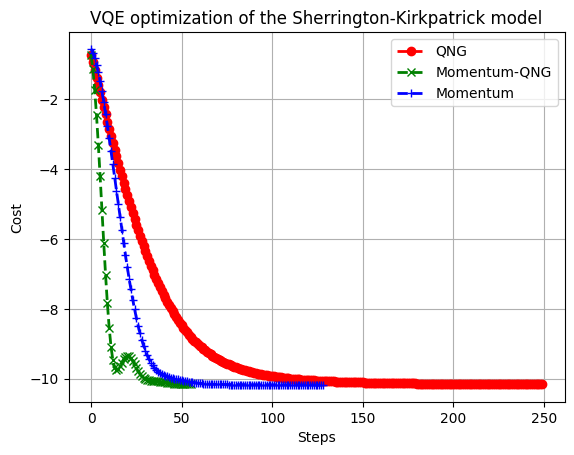

In [ ]:
import matplotlib.pyplot as plt

label_1 = 'QNG'
label_2 = 'Momentum-QNG'
label_3 = 'Momentum'

plt.plot(qng_cost, color='r', marker='o', linestyle='--', linewidth = 2.0, label=label_1)
plt.plot(momentum_qng_cost, color='g', marker='x', linestyle='--', linewidth = 2.0, label=label_2)
plt.plot(momentum_cost, color='b', marker='+', linestyle='--', linewidth = 2.0, label=label_3)



plt.title('VQE optimization of the Sherrington-Kirkpatrick model')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.legend(loc='upper right')
plt.grid()

plt.show()

One can see that Momentum-QNG chooses the steepest descent path, passes the local minimum and climbs the barrier before converging in some shallow local minimum very close to the global one. On the contrary, both QNG and Momentum choose less steep, but convex descent path, which results in somewhat longer convergence story. Therefore, combination of the nonzero momentum (or inertial) term, applied in the Momentum algorithm with the quantum metric tensor, applied in the QNG algorithm, can result in a synergetic effect (if you are lucky;-)